# 内容及结论

1. 基于研报的策略进行的复现，主要数据差别在于：因子从70个缩小至45个、时长从16年缩短至4年；在随机森林的参数选择中，原文似乎手动遍历了，这里直接用了GridSearchCV；原文用linear regression做对照，这里用logistic regression做对照。
2. 从1. 数据获取跑到4. 训练集和交叉验证集合成后生成df_factor_1后，可以直接运行main_func，并用main_func调参
3. 可调参数:period_len,val_len,param_grid,也可以回insample_train函数中调max_features,cv
4. 粗调效果:period_len越大,param_grid参数越多,max_features越大和cv越大,会导致训练时间急剧增长(默认参数7min);param_grid参数的增多也会使dtc的效果变好(如果按默认，直接设定而不网格搜索的话,效果与lr相似)
5. 返回结果:auc_compare:dataframe,比较dtc和lr的auc值;dtc_tier_ret,lr_tier_ret:dataframe,分布记录dtc和lr的全validation时长的分箱ret
6. print结果:分阶段回测+根据dtc_tier_ret,lr_tier_ret计算的全validation时长的多空回测

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.options.display.max_rows = 200
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

import warnings
warnings.filterwarnings('ignore')

e:\programs\anaconda\envs\python38\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
e:\programs\anaconda\envs\python38\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
e:\programs\anaconda\envs\python38\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
e:\programs\anaconda\envs\python38\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [43]:
df_factor_1 = pd.read_csv('df_factor_1.csv',index_col=0).reset_index().drop(columns='index')
df_factor_1['TICKER_SYMBOL'] = df_factor_1['TICKER_SYMBOL'].map(lambda x:str(x).zfill(6))
df_factor_1['TRADE_DATE'] = pd.to_datetime(df_factor_1.TRADE_DATE)
df_factor_1

df_factor = pd.read_csv('df_factor.csv',index_col=0).reset_index().drop(columns='index')
df_factor['TICKER_SYMBOL'] = df_factor['TICKER_SYMBOL'].map(lambda x:str(x).zfill(6))
df_factor['TRADE_DATE'] = pd.to_datetime(df_factor.TRADE_DATE)
df_factor


,TICKER_SYMBOL,TRADE_DATE,closePrice,LCAP
0,000001,2018-04-30,10.850,25.950619
1,000002,2018-04-30,28.400,26.471103
2,000004,2018-04-30,20.850,21.283404
3,000005,2018-04-30,3.580,22.055516
4,000006,2018-04-30,6.990,22.967847
...,...,...,...,...
193981,872925,2022-03-31,15.640,20.448966
193982,872925,2022-04-29,15.690,20.452158
193983,873169,2022-04-29,6.210,20.005407
193984,900905,2018-09-28,3.255,21.255510


In [24]:
weight_ins = pd.read_csv('weight_ins.csv',index_col=0,parse_dates=True)
weight_ins['TRADE_DATE'] = pd.to_datetime(weight_ins.TRADE_DATE)
weight_ins

,TRADE_DATE,industryName1,weight_ins
0,2018-06-29,交通运输,0.035529
1,2018-06-29,休闲服务,0.007477
2,2018-06-29,传媒,0.025856
3,2018-06-29,公用事业,0.033492
4,2018-06-29,农林牧渔,0.004792
...,...,...,...
1311,2022-04-29,采掘,0.012517
1312,2022-04-29,钢铁,0.006883
1313,2022-04-29,银行,0.127582
1314,2022-04-29,非银金融,0.101439


In [30]:
index_cum = pd.read_csv('index_cum.csv',index_col=0,parse_dates=True)
index_cum 

,closeIndex
TRADE_DATE,
2018-01-31,NaN
2018-02-28,0.941005
2018-03-30,0.911738
2018-04-30,0.878617
2018-05-31,0.889258
2018-06-29,0.821110
2018-07-31,0.822671
2018-08-31,0.779837
2018-09-28,0.804244


In [35]:
Industry = pd.read_csv('Industry18-22.csv',index_col=0)
Industry.TRADE_DATE = pd.to_datetime(Industry.TRADE_DATE)
Industry.TICKER_SYMBOL = Industry.TICKER_SYMBOL.apply(lambda x:str(x).zfill(6)[-6:])
Industry = Industry[['TICKER_SYMBOL','TRADE_DATE','industryName1']]
Industry

,TICKER_SYMBOL,TRADE_DATE,industryName1
0,000001,2018-01-31,银行
1,000001,2018-02-28,银行
2,000001,2018-03-30,银行
3,000001,2018-04-30,银行
4,000001,2018-05-31,银行
...,...,...,...
217584,600018,2021-12-31,交通运输
217585,600018,2022-01-31,交通运输
217586,600018,2022-02-28,交通运输
217587,600018,2022-03-31,交通运输


# 5. 样本内训练：

考虑到我们的数据只有四年，将2018-2022四年的数据作为一个回测区间，对该回测区间的不同训练集重复训练。

In [22]:
def insample_train(period,df_train_x,df_train_y,param_grid,method='rf'):
    train_x = df_train_x[df_train_x.period_==period].drop(columns='period_')
    train_y = df_train_y[df_train_y.period_==period].drop(columns='period_')
    x_train, x_test, y_train, y_test = train_test_split(train_x, train_y.values, test_size=0.1, random_state=1)

    # n_estimators = 100, 原研报用了500，考虑到我们的数据几乎是原数据1/4，这里用100
    # max_features,我们用了45个因子
    # max_depth/min_samples_leaf/max_leaf_nodes 限制剪枝情况，原研报中用的是min_samples_leaf/max_leaf_nodes(s)
    if method=='rf':
        base = RandomForestClassifier() #max_features=45
        grid = GridSearchCV(base, param_grid=param_grid, cv=5) 
        grid.fit(x_train, y_train)
        estimator_ = grid.best_estimator_
        estimator_train = estimator_.predict_proba(x_train)
        estimator_test = estimator_.predict_proba(x_test)

    # LR可作为对照组
    if method=='lr':
        estimator_ = LogisticRegressionCV(Cs=100, max_iter=1000) 
        estimator_.fit(x_train, y_train.ravel())
        estimator_train = estimator_.predict_proba(x_train)
        estimator_test = estimator_.predict_proba(x_test)
        
    return y_test,estimator_,estimator_train,estimator_test



# 6. 交叉验证调参：

选择第一区段训练模型，训练完成后，使用该模型对交叉验证集进行预测。选取交叉验证集 AUC（或平均 AUC）最高的一组参数作为模型的最优参数。

# 7. 样本外测试：

确定最优参数后，以 T 月月末截面期所有样本（即个股）预处理后的特征作为模型的输入，得到每个样本的 T+1 月的预测值𝑓(𝒙)（合成因子，即随机森林中各决策树分类结果的投票平均值），可以根据该预测值构建策略组合

# 8. 分层回测分析

换仓期：在每个自然月最后一个交易日核算因子值，在下个自然月首个交易日按当日收盘价换仓。

数据处理方法：将随机森林模型的预测值视作单因子，因子值为空的股票不参与分层。

分层方法：

a) 在每个一级行业内部对所有个股按因子大小进行排序，每个行业内均分成N 个分层组合，各行业内个股初始权重取相等权重。

b) N 等分行业内个股权重累加值，记为N个组合。

c) 行业间权重配比与基准组合（我们使用沪深 300）相同，也即行业中性。


In [44]:
pred_class = ['drop','rise']
def period_cv(y_test,estimator_test):
    yy_test = label_binarize(y_test, classes=[0,1,2])

    estimator_fpr = dict(); estimator_tpr = dict(); estimator_roc_auc = dict()

    estimator_fpr[1], estimator_tpr[1], _ = roc_curve(yy_test[:, 1], estimator_test[:, 1])
    estimator_roc_auc[1] = auc(estimator_fpr[1], estimator_tpr[1])

    return estimator_roc_auc,estimator_fpr[1], estimator_tpr[1]

In [58]:
def outsample_test(period,estimator_,df_val_x,df_val_y,weight_ins=weight_ins):
    val_x = df_val_x[df_val_x.period_==period].drop(columns='period_')
    val_y = df_val_y[df_val_y.period_==period].drop(columns='period_')

    df_val_estimator = pd.DataFrame(columns=pred_class)
    for i in range(len(val_x.TRADE_DATE.unique())-1):
        date,p_date  = list(val_x.TRADE_DATE.unique())[i],list(val_x.TRADE_DATE.unique())[i+1]
        pred_val_estimator= pd.DataFrame(estimator_.predict_proba(val_x[val_x.TRADE_DATE==date].set_index(['TRADE_DATE','TICKER_SYMBOL']))).assign(TRADE_DATE=p_date).rename(columns={0:'drop',1:'rise'})
        df_val_estimator = pd.concat([df_val_estimator,pd.concat([val_y[val_y.TRADE_DATE==date].reset_index().drop(columns=['index','ret','TRADE_DATE']),pred_val_estimator],axis=1)],axis=0)

    df_val_estimator.reset_index().drop(columns='index')

    df_val_ret = df_factor.pivot_table(index='TRADE_DATE',columns='TICKER_SYMBOL',values='closePrice').ffill().pct_change().shift(-1).T.stack().reset_index().rename(columns={0:'ret'})
    df_val_estimator = pd.merge(df_val_estimator,df_val_ret,on=['TRADE_DATE','TICKER_SYMBOL'],how='left').dropna(subset='ret')

    df_val_estimator = pd.merge(df_val_estimator,Industry,on=['TRADE_DATE','TICKER_SYMBOL'],how='left').dropna(how='any')
    df_val_estimator = pd.merge(df_val_estimator,weight_ins,on=['TRADE_DATE','industryName1'],how='left').dropna(how='any')

    df_val_estimator_rank = pd.DataFrame(columns=['TICKER_SYMBOL','TRADE_DATE','rank_'])
    val_ins = df_val_estimator.industryName1.unique()
    for ins in val_ins:
        df_ins_temp_estimator = df_val_estimator[df_val_estimator.industryName1==ins]
        df_ins_temp_estimator = df_ins_temp_estimator.pivot_table(index='TICKER_SYMBOL',columns='TRADE_DATE',values='rise').apply(lambda x: pd.qcut(x, 5, labels=False,duplicates='drop'), axis=1).stack().reset_index().rename(columns={0:'rank_'})
        df_val_estimator_rank = df_val_estimator_rank.append(df_ins_temp_estimator)

    df_val_estimator_rank['TRADE_DATE'] = pd.to_datetime(df_val_estimator_rank['TRADE_DATE'])
    df_val_estimator['TRADE_DATE'] = pd.to_datetime(df_val_estimator['TRADE_DATE'])
    df_val_estimator_rank = pd.merge(df_val_estimator_rank,df_val_estimator,on=['TICKER_SYMBOL','TRADE_DATE'],how='left')

    return df_val_estimator_rank


In [75]:
def factor_test(df,y_test,estimator_test,factor_name='rise', freq='BM', factor_ascending=True,tier_num=5,index_cum=index_cum):
    num = 0
    df_tier_ret = pd.DataFrame()
    df['return_ranking']= df.groupby('TRADE_DATE')['ret'].rank(ascending=False)
    df['factor_ranking']= df.groupby('TRADE_DATE')[factor_name].rank(ascending=factor_ascending)
    df[[factor_name,'ret']] = df[['rise','ret']].astype('float32')

    ##IC
    IC_list = df.groupby('TRADE_DATE').apply(lambda x:x[factor_name].corr(x.ret))
    print('IC_mean = '+ str(IC_list.mean()))
    print('IC_std = '+ str(IC_list.std()))
    print('IC_positive_prob = '+ str(format(len(IC_list[IC_list>=0])/len(IC_list),'0.0%')))
    print('IR = '+ str(IC_list.mean()/IC_list.std()))

    ##Rank IC
    RIC_list = df.groupby('TRADE_DATE').apply(lambda x:x.factor_ranking.corr(x.return_ranking,method='pearson'))
    print('Rank IC mean = '+ str(RIC_list.mean()))
    print('Rank IC std = '+ str(RIC_list.std()))
    print('Rank IC positive prob = '+ str(format(len(RIC_list[RIC_list>=0])/len(RIC_list),'0.0%')))
    print('Rank_IC_IR = '+ str(RIC_list.mean()/RIC_list.std()))

    #单调性
    def level_separate(df,i):
        df_temp = df[df.rank_==i]
        df_temp = df_temp.groupby(['TRADE_DATE','industryName1'])[['ret','weight_ins']].mean().reset_index()
        sum_ = df_temp.groupby('TRADE_DATE').apply(lambda x: np.array(x.ret).dot(np.array(x.weight_ins)))
        return sum_

    estimator_roc_auc,estimator_fpr, estimator_tpr = period_cv(y_test,estimator_test)

    plt.figure(figsize=(20,10))
    plt.subplot(2,2,1)
    plt.plot(estimator_fpr, estimator_tpr, label='ROC curve (area = %0.2f)' % estimator_roc_auc[1])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(" rise VS drop")
    plt.legend(loc="lower right")

    plt.subplot(2,2,2)
    plt.plot(index_cum,label='300_Index',color='red', linestyle=':')
    df_tier_ret['index300'] = index_cum
    for i in range(tier_num):
        tier_ret = level_separate(df,i)
        df_tier_ret['tier'+str(i+1)] = tier_ret
        plt.plot((tier_ret+1).cumprod(),label='tier '+str(i+1))
        plt.legend()  
    plt.title('portfolio cut by rank_')

    plt.subplot(2,2,3)
    for i in range(tier_num):
        t = ((level_separate(df,i)+1).cumprod()-index_cum.T).ffill().T
        plt.plot(t,label='tier '+str(i+1))
        plt.legend()  
    plt.title('excess return cut by rank_')

    #long short porfolio 
    first_ = (level_separate(df,0) - level_separate(df,tier_num-1)+1).cumprod().shift(1)[-1]
    last_ = (level_separate(df,tier_num-1) - level_separate(df,0)+1).cumprod().shift(1)[-1]
    if first_>last_:
        long_short_port = level_separate(df,0) - level_separate(df,tier_num-1)
    else:
        long_short_port = level_separate(df,tier_num-1) - level_separate(df,0)
    long_short_port_cum = (long_short_port+1).cumprod().shift(1)
    long_short_port_cum[0]=1
    plt.subplot(2,2,4)
    plt.plot(long_short_port_cum)
    plt.title('long short portfolio performance')
    plt.show()

    if freq=='BM':
        num=12
    if freq=='B':
        num=252
    if freq=='Q':
        num=4
    if freq=='W':
        num=52
    if freq=='6M':
        num=2


    annual_ret=long_short_port_cum[-1]**(1/(len(long_short_port)/num))-1
    print('Annualized return of long-short porfolio: '+ str(format(annual_ret,'0.0%')))
    annual_vol = long_short_port.std()*(num**0.5)
    print('Sharp ratio of long-short portfolio: ' + str(round(annual_ret/annual_vol,3)))
    print ('Maximum drawdown of long-short portfolio: '+
            str(format(((long_short_port_cum - long_short_port_cum.cummax())/long_short_port_cum.cummax()).min(),'0.0%')))
    print ('Win rate of long-short portfolio: ' + str(format(len(long_short_port[long_short_port>0])/len(long_short_port),'0.0%')))

    return df_tier_ret,estimator_roc_auc

In [77]:
def test_all_period(tier_ret, df_auc,freq='BM', tier_num=5,index_cum=index_cum):
    num = 0
    
    plt.figure(figsize=(20,10))
    plt.subplot(2,2,1)
    index_cum = index_cum[(index_cum.index>=tier_ret.index.min())&(index_cum.index<=tier_ret.index.max())]
    plt.plot(index_cum,label='300_Index',color='red', linestyle=':')
    # tier_ret['index300'] = index_cum
    for i in range(1,tier_num+1):
        plt.plot((tier_ret.iloc[:,i]+1).cumprod(),label='tier '+str(i))
        plt.legend()  
    plt.title('portfolio cut by rank_')

    tier_first = (tier_ret.iloc[:,1]+1).cumprod()[-1] ; tier_last = (tier_ret.iloc[:,tier_num]+1).cumprod()[-1] 
    plt.subplot(2,2,2)
    for i in range(1,tier_num+1):
        plt.plot(((tier_ret.iloc[:,i]+1).cumprod()-index_cum.T).ffill().T,label='tier '+str(i))
        plt.legend() 
    plt.title('excess return cut by rank_')

    #long short porfolio 
    if tier_first > tier_last:
        long_short_port = tier_ret.iloc[:,1] - tier_ret.iloc[:,tier_num]
    else:
        long_short_port = tier_ret.iloc[:,tier_num] - tier_ret.iloc[:,1]
    long_short_port_cum=(long_short_port+1).cumprod().shift(1)
    long_short_port_cum[0]=1
    plt.subplot(2,2,3)
    plt.plot(long_short_port_cum)
    plt.title('long short portfolio performance')

    plt.subplot(2,2,4)
    plt.plot(df_auc,label=df_auc.columns.values[0])
    plt.legend()
    plt.title('AUC score')
    plt.show()

    if freq=='BM':
        num=12
    if freq=='B':
        num=252
    if freq=='Q':
        num=4
    if freq=='W':
        num=52
    if freq=='6M':
        num=2


    annual_ret=long_short_port_cum[-1]**(1/(len(long_short_port)/num))-1
    print('Annualized return of long-short porfolio: '+ str(format(annual_ret,'0.0%')))
    annual_vol = long_short_port.std()*(num**0.5)
    print('Sharp ratio of long-short portfolio: ' + str(round(annual_ret/annual_vol,3)))
    print ('Maximum drawdown of long-short portfolio: '+
            str(format(((long_short_port_cum - long_short_port_cum.cummax())/long_short_port_cum.cummax()).min(),'0.0%')))
    print ('Win rate of long-short portfolio: ' + str(format(len(long_short_port[long_short_port>0])/len(long_short_port),'0.0%')))

# main_func及结果

In [53]:
def main_func(period_len = 24,val_len = 6,df_factor_1=df_factor_1,param_grid = {'max_leaf_nodes': [30], 'min_samples_leaf': [5],'max_features':[8]},method='rf'):
    """
    可调参数:period_len,val_len,param_grid,也可以回insample_train函数中调max_features,cv
    粗调效果:period_len越大,param_grid参数越多,max_features越大和cv越大,会导致训练时间急剧增长(默认参数7min);param_grid参数的增多也会使模型的效果变好
    返回结果:auc_compare:dataframe,auc值;df_tier_ret:dataframe,分布记录该模型的全validation时长的分箱ret
    print结果:分阶段回测+根据df_tier_ret,lr_tier_ret计算的全validation时长的多空回测
    """
    method_name = 'Random Forest'
    if method=='lr':
        method_name = 'Logistic Regression'
    auc_compare = pd.DataFrame(columns=[method_name])
    df_tier_ret = pd.DataFrame()

    date_list = df_factor_1.TRADE_DATE.unique()
    df_factor_val = pd.DataFrame();df_factor_train=pd.DataFrame()
    train_list = [];val_list = []

    for i in range((len(date_list)-period_len)//val_len+1):
        start_train = date_list[i*val_len]
        end_train = date_list[i*val_len+period_len-val_len]
        end_val = date_list[i*val_len+period_len]
        train_list.append(end_train)
        val_list.append(end_val)
        df_factor_val = df_factor_val.append(df_factor_1[df_factor_1.TRADE_DATE>=end_train][df_factor_1.TRADE_DATE<=end_val].assign(period_=i))
        df_factor_train = df_factor_train.append(df_factor_1[df_factor_1.TRADE_DATE<=end_train][df_factor_1.TRADE_DATE>=start_train].assign(period_=i))
        df_train_x = df_factor_train.set_index(['TRADE_DATE','TICKER_SYMBOL']).drop(columns='ret')
        df_train_y = df_factor_train.set_index(['TRADE_DATE','TICKER_SYMBOL'])[['ret','period_']]
        df_val_x = df_factor_val.set_index(['TRADE_DATE','TICKER_SYMBOL']).drop(columns='ret').reset_index()
        df_val_y = df_factor_val.set_index(['TRADE_DATE','TICKER_SYMBOL'])[['ret','period_']].reset_index()

    for i in range((len(date_list)-period_len)//val_len+1):
        y_test,estimator_,_,estimator_test = insample_train(i,df_train_x,df_train_y,param_grid,method='rf')
        val_start,val_end = train_list[i],val_list[i]

        df_val_estimator_rank = outsample_test(i,estimator_,df_val_x,df_val_y)
        val_s , val_e= ''.join(str(val_start).split('T')[0].split('-')), ''.join(str(val_end).split('T')[0].split('-'))
        index_cum_temp = index_cum[(index_cum.index>val_s)&(index_cum.index<=val_end)]
        print('='*10+'backtest period '+str(i+1)+': validation period starts at '+ val_s + ' and ends at '+ val_e + '='*10)
        print('-'*5+ method_name + 'strategy\s result'+ '-'*5)
        df_tier_ret_temp,estimator_roc_auc = factor_test(df_val_estimator_rank,y_test,estimator_test,index_cum=index_cum_temp)
        df_tier_ret = df_tier_ret.append(df_tier_ret_temp)
        auc_compare.loc[str(i),:] = [estimator_roc_auc[1]]

    test_all_period(df_tier_ret.dropna(subset=list(df_tier_ret.columns.values)[1:],how='any'),auc_compare)
    return auc_compare,df_tier_ret

==========backtest period 1: validation period starts at 20191031 and ends at 20200430==========
-----Random Foreststrategy\s result-----
IC_mean = -0.0039003807258193076
IC_std = 0.05762377374488566
IC_positive_prob = 50%
IR = -0.06768700611465041
Rank IC mean = 0.0035009546939356825
Rank IC std = 0.06732030773850076
Rank IC positive prob = 33%
Rank_IC_IR = 0.05200443687118608


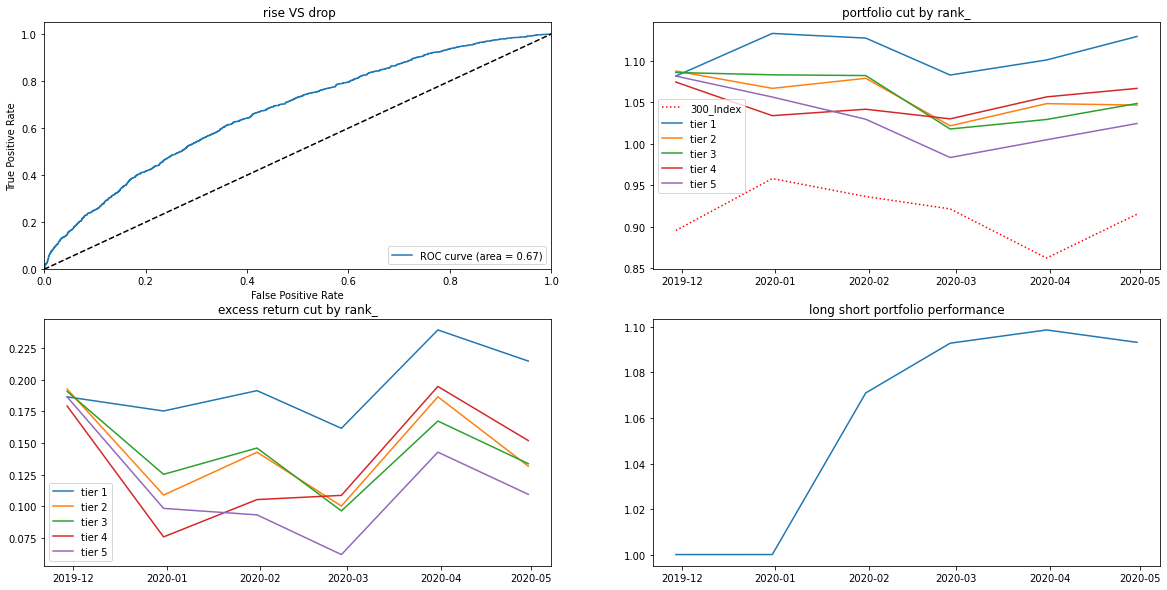

Annualized return of long-short porfolio: 20%
Sharp ratio of long-short portfolio: 2.005
Maximum drawdown of long-short portfolio: -0%
Win rate of long-short portfolio: 83%
==========backtest period 2: validation period starts at 20200430 and ends at 20201030==========
-----Random Foreststrategy\s result-----
IC_mean = -0.02007386226695455
IC_std = 0.07208721459765463
IC_positive_prob = 33%
IR = -0.2784663324695536
Rank IC mean = 0.03318816955968087
Rank IC std = 0.09035940258517995
Rank IC positive prob = 67%
Rank_IC_IR = 0.36729071474764413


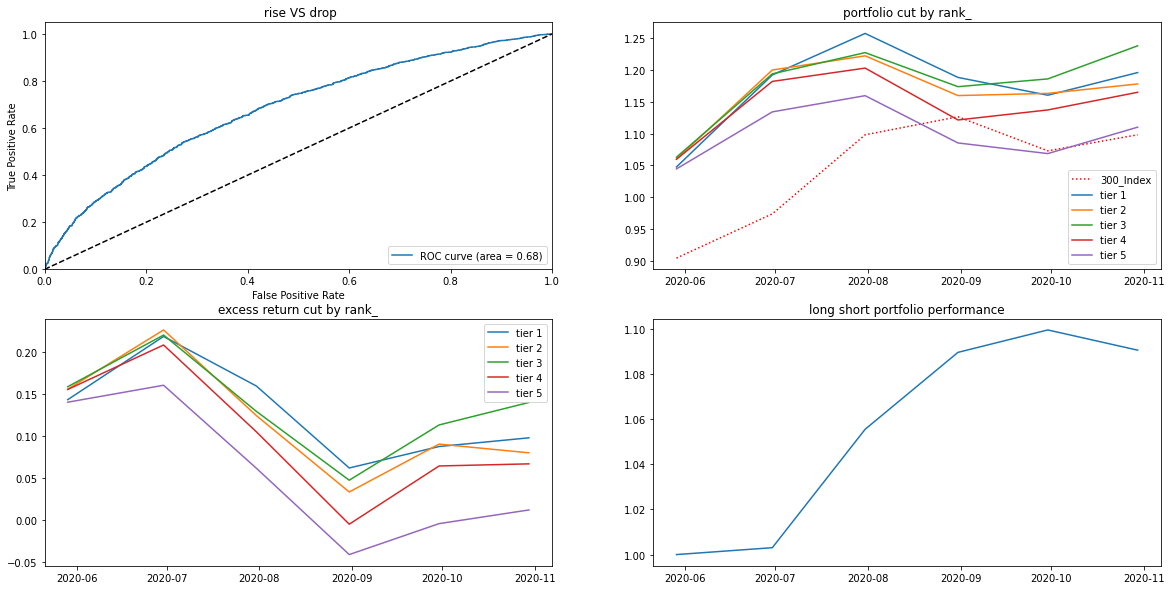

Annualized return of long-short porfolio: 19%
Sharp ratio of long-short portfolio: 2.259
Maximum drawdown of long-short portfolio: -1%
Win rate of long-short portfolio: 67%
==========backtest period 3: validation period starts at 20201030 and ends at 20210430==========
-----Random Foreststrategy\s result-----
IC_mean = -0.022798157766937777
IC_std = 0.0610876477389849
IC_positive_prob = 33%
IR = -0.3732040536959234
Rank IC mean = 0.051632678503127284
Rank IC std = 0.06452834280892099
Rank IC positive prob = 67%
Rank_IC_IR = 0.800155036617322


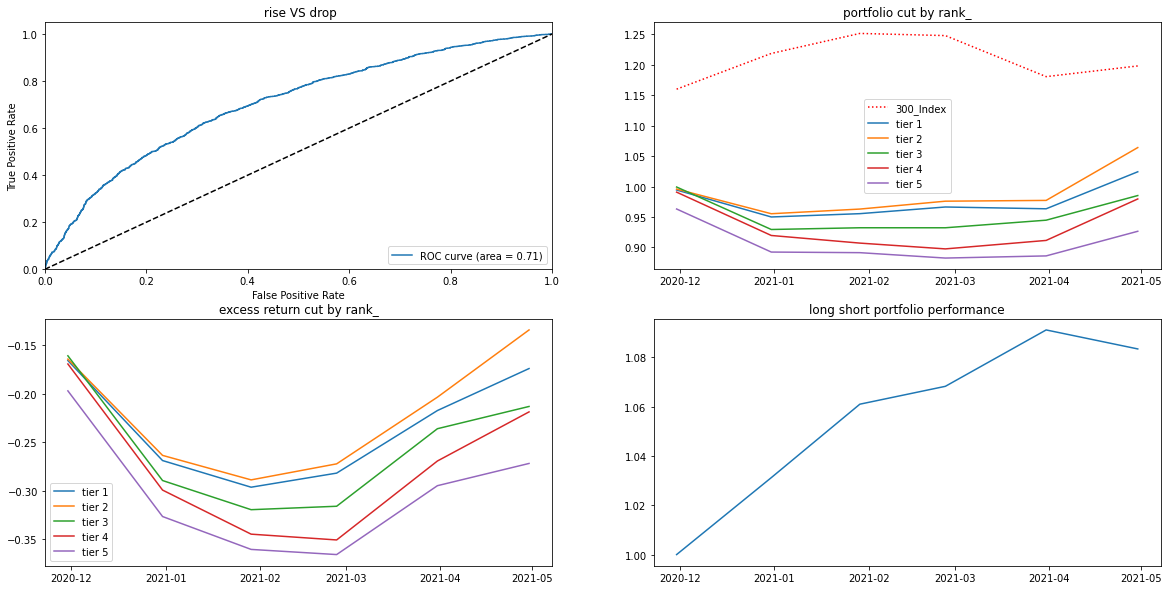

Annualized return of long-short porfolio: 17%
Sharp ratio of long-short portfolio: 3.473
Maximum drawdown of long-short portfolio: -1%
Win rate of long-short portfolio: 83%
==========backtest period 4: validation period starts at 20210430 and ends at 20211029==========
-----Random Foreststrategy\s result-----
IC_mean = -0.022174081344915757
IC_std = 0.08057168343430052
IC_positive_prob = 50%
IR = -0.2752093589182218
Rank IC mean = 0.05976758378442212
Rank IC std = 0.08056090262208188
Rank IC positive prob = 67%
Rank_IC_IR = 0.7418931744694693


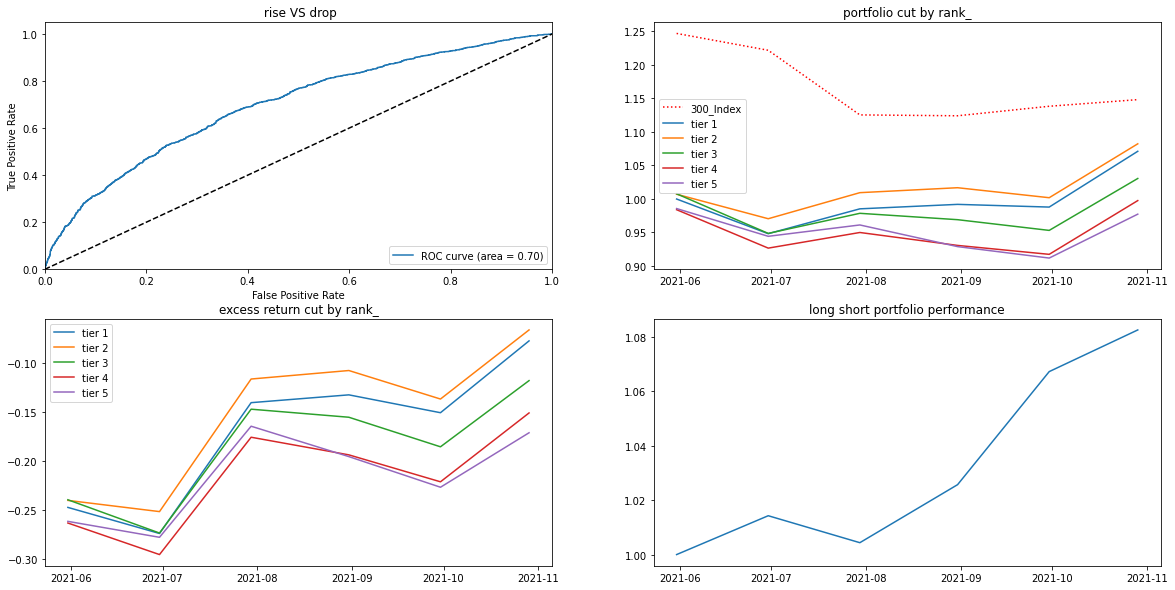

Annualized return of long-short porfolio: 17%
Sharp ratio of long-short portfolio: 3.067
Maximum drawdown of long-short portfolio: -1%
Win rate of long-short portfolio: 83%
==========backtest period 5: validation period starts at 20211029 and ends at 20220429==========
-----Random Foreststrategy\s result-----
IC_mean = -0.010135744709982927
IC_std = 0.05688210291056907
IC_positive_prob = 40%
IR = -0.17818864267234463
Rank IC mean = 0.017255273725866025
Rank IC std = 0.06660865872042611
Rank IC positive prob = 80%
Rank_IC_IR = 0.2590545141929806


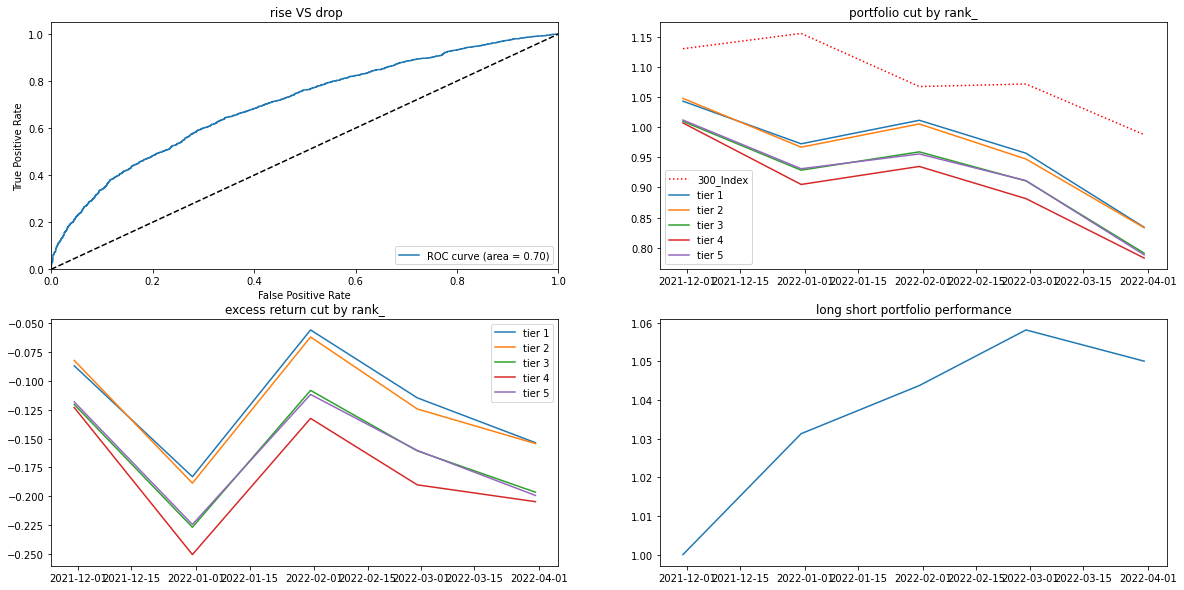

Annualized return of long-short porfolio: 12%
Sharp ratio of long-short portfolio: 2.559
Maximum drawdown of long-short portfolio: -1%
Win rate of long-short portfolio: 80%


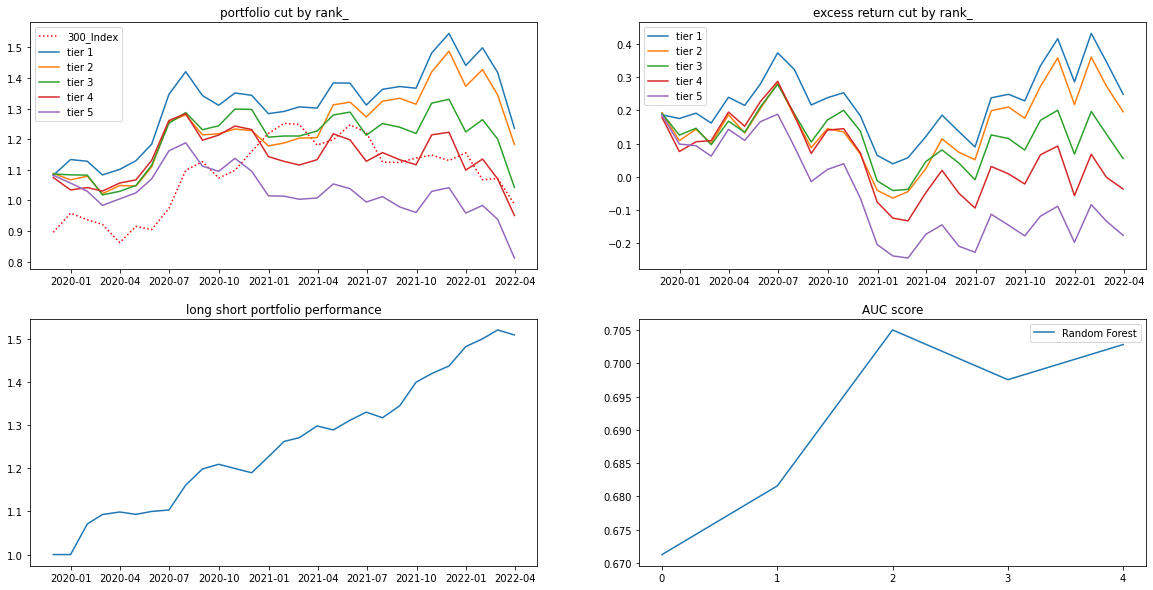

Annualized return of long-short porfolio: 19%
Sharp ratio of long-short portfolio: 2.82
Maximum drawdown of long-short portfolio: -2%
Win rate of long-short portfolio: 79%


In [78]:
auc_compare,df_tier_ret = main_func()

In [80]:
Auc_compare_all,Df_tier_ret_all = auc_compare.assign(period_len = 24,val_len = 6),df_tier_ret.assign(period_len = 24,val_len = 6)

In [81]:
Auc_compare_all

,Random Forest,period_len,val_len
0,0.67123,24,6
1,0.681553,24,6
2,0.705013,24,6
3,0.697533,24,6
4,0.702815,24,6
